In [38]:
%matplotlib inline
 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV

import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
import graphviz 
import pydotplus 
import pydot 

from IPython.display import Image 
import warnings
warnings.filterwarnings("ignore")


# Increase viewable area of Pandas tables, numpy arrays, plots
#pd.set_option('max_rows',15,'max_columns',500,'max_colwidth',1,'precision',2)
np.set_printoptions(linewidth=10000, precision=4,edgeitems=20,suppress=True)
sns.set()
plt.rcParams['figure.figsize'] = [16,6]

 


In [39]:
# Data Dictionary
# Variable	Definition	Key
# survival 	Survival 	0 = No, 1 = Yes
# pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
# sex 	Sex 	
# Age 	Age in years 	
# sibsp 	# of siblings / spouses aboard the Titanic 	
# parch 	# of parents / children aboard the Titanic 	
# ticket 	Ticket number 	
# fare 	Passenger fare 	
# cabin 	Cabin number 	
# embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
# Variable Notes

# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower

# age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

# sibsp: The dataset defines family relations in this way...
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)

# parch: The dataset defines family relations in this way...
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

In [40]:
#downloading data
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')
cols_2_drop = ['PassengerId','Ticket','Cabin','Name']
data.head()




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
data =data.drop(cols_2_drop, axis = 1)
data.loc[:,'Age'] = data.Age.fillna(-999)

data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Exploratory Data Analysis

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [43]:
data.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [44]:
#пропусков в данных нет, но есть 2 категориальных признаков (Sex, Embarked). Закодируем их с помощью OrdinalEncoder

enc =  OrdinalEncoder()
data[['Sex','Embarked']] = enc.fit_transform(data[['Sex','Embarked']])
data.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.2500,2.0
1,1,1,0.0,38.0,1,0,71.2833,0.0
2,1,3,0.0,26.0,0,0,7.9250,2.0
3,1,1,0.0,35.0,1,0,53.1000,2.0
4,0,3,1.0,35.0,0,0,8.0500,2.0


In [45]:
X = data.drop('Survived', axis=1)
Y = data['Survived']
#train_test_split
train_X,test_X,train_Y,test_Y = train_test_split(X,Y, test_size=0.2, random_state=42)
train_X.shape, test_X.shape, train_Y.shape,test_Y.shape

((711, 7), (178, 7), (711,), (178,))

### Begin with simple begging

We begin to learn ansymble of tree models using bagging

<img src='date/math1.jpg'>

In [46]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1, n_estimators=100,random_state=42)
model.fit(train_X,train_Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=100, n_jobs=-1, random_state=42)

In [47]:
print(f'Bagged trees accuracy score {accuracy_score(model.predict(test_X),test_Y):.4f}')

Bagged trees accuracy score 0.7978


In [48]:
# look at single tree
def plot_tree(model,X,fname='temp_tree.png'):
    dot_data = export_graphviz(model,filled=True,rounded=True,feature_names=X.columns, out_file = None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

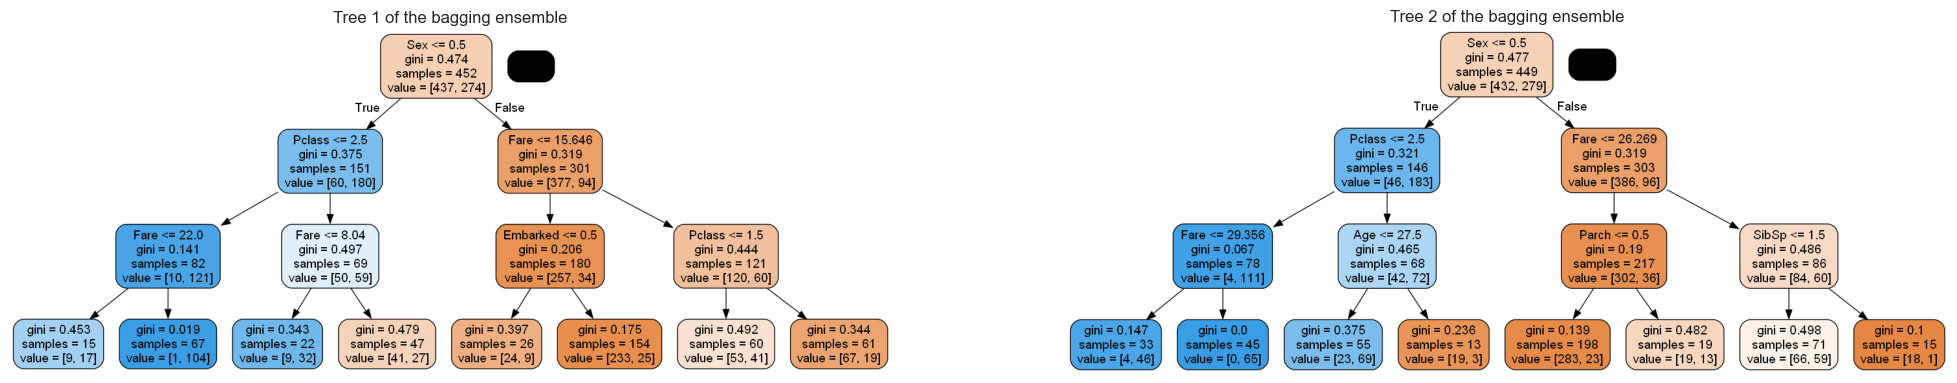

In [49]:
tree1, tree2 = model.estimators_[0],model.estimators_[1]

plt.figure(figsize=(25,15))
plt.subplot(1,2,1)
plot_tree(tree1,train_X)
plt.axis('off')
plt.title(f'Tree 1 of the bagging ensemble')
plt.subplot(1,2,2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the bagging ensemble')
plt.show()


<img src='date/math2.jpg'>

### Random forest

In [50]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth= 3, oob_score=True, random_state=42)
model.fit(train_X, train_Y)

RandomForestClassifier(max_depth=3, n_jobs=-1, oob_score=True, random_state=42)

In [51]:
# print score
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Actual test score: 0.7978


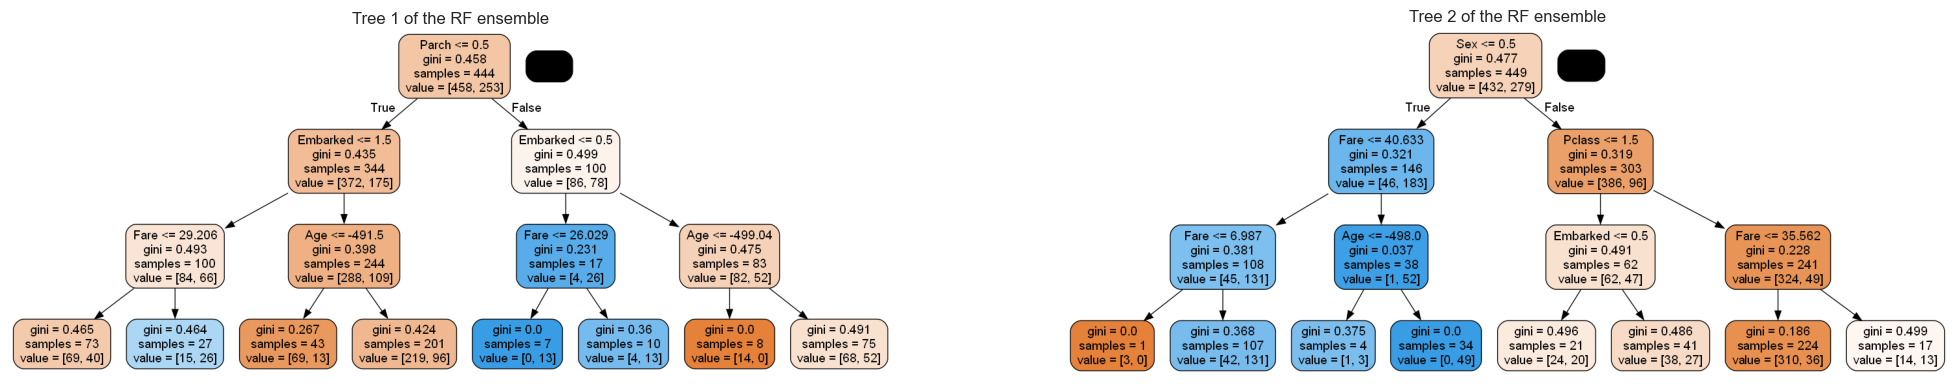

In [52]:
tree1,tree2 = model.estimators_[2], model.estimators_[1]

plt.figure(figsize=(25,15))
plt.subplot(1,2,1)
plot_tree(tree1,train_X)
plt.axis('off')
plt.title(f'Tree 1 of the RF ensemble')
plt.subplot(1,2,2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the RF ensemble')
plt.show()


In [54]:
# Now lets try realistic max depth
model = RandomForestClassifier(n_estimators=300, n_jobs=-1, max_depth= 5, oob_score=True, random_state=42)
model.fit(train_X, train_Y)
# print score
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Actual test score: 0.8034


### Hyperparameters models

<img src='date/math3.jpg'>

<img src='date/math4.jpg'>

<img src='date/math5.jpg'>

In [67]:
forest_params = {'max_depth' : [2,5,10], 'max_features': ['sqrt'], 'n_estimators' : [100, 300,500]}
model = RandomForestClassifier(random_state=42)
clf = GridSearchCV(model,forest_params,cv=10, scoring='accuracy')

In [68]:
clf.fit(train_X,train_Y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 5, 10], 'max_features': ['sqrt'],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [69]:
# best combination
clf.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}

In [70]:
print(f'Actual test score: {accuracy_score(clf.predict(test_X), test_Y):.4f}')

Actual test score: 0.7921
